# Test des modeles de segmentation et classification sur le nouveau dataset
Au prealable, on a selectionne 723 images non redondantes avec le dataset initial depuis le jeu de donnees COVIDNET
On conserve les sources actmed, fig1, cohen


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from PIL import Image

%matplotlib inline
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler



In [4]:
# Import des donnees 

path = r"C:\Users\Inrae\Documents\Projet_Data_Science\COVID_NET\BIMCV"
dim=256
final_size=(dim, dim)

# Import des données on sépare entre apprentissage et validation
batch_size=32
size=final_size

# Nombre de donnes max par categorie
size_max_cat = 2000



## Import des fichiers

In [7]:
def getData(X_shape, N = None):
    im_array = []
    target_array = []

    for cat in ["positive", "negative"]:       
        image_path = os.path.join(path,cat)
        target = cat
        files = os.listdir(image_path)
        random.Random(1337).shuffle(files)
        
        if (N is None):
            N = len(files)
        else:
            N = min(N, len(files))
        for i in files[:N]: 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            target=cat
            im_array.append(im)
            target_array.append(target)
            
    images = np.array(im_array).reshape(len(im_array),dim,dim,1)
    return images, target_array


In [8]:
# Importing data
dim = 256
images, labels = getData(dim,N=size_max_cat)

print("dataset size : images", images.shape, "labels", len(labels))


dataset size : images (4000, 256, 256, 1) labels 4000


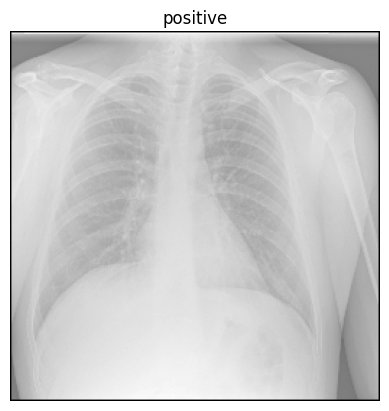

In [9]:
# On verifie que l'import s'est bien passé
i=3

plt.imshow(images[3], cmap="gray")
plt.axis("off")
plt.title(labels[3])
plt.show()

## Segmentation : Génération des masques

In [ ]:
# Import du modèle
model_seg = tf.keras.models.load_model("cxr_reg_segmentation.best.keras")

In [17]:
# Calcul des masques

images_scaled = (images-127)/127

print("Shape de image_scaled: ", images_scaled.shape, "type de image_scaled: ", images_scaled.dtype)

# # On predit sur dataset
masks = model_seg.predict(images_scaled)

# On convertit en 0-255

masks[masks>0.5] = 255
masks[masks<=0.5] = 0



Shape de image_scaled:  (4000, 256, 256, 1) type de image_scaled:  float64
125/125 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step


#  Masquage des images

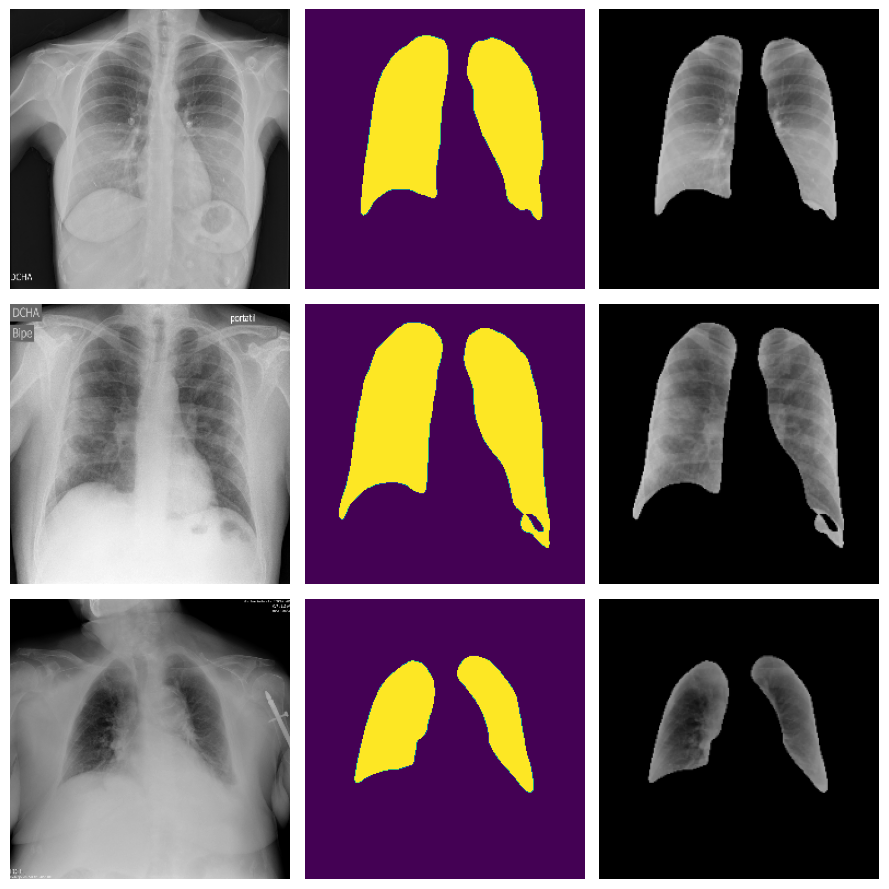

In [18]:
# Preparation des donnees, on masque les images
masked_image_array=[]

for i in range(images.shape[0]) : 
    img = images[i]
    msk = masks[i].astype(img.dtype)
    masked_image = cv2.bitwise_and(img, msk)
    masked_image = cv2.resize(masked_image, dsize = (224, 224))
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
    masked_image_array.append(masked_image)

masked_images = np.array(masked_image_array).reshape(len(masked_image_array),224,224,3)

import random
import matplotlib.pyplot as plt

# On trace le graph pour 3 images

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for i in range(0, 9, 3):
    j = random.randint(0, len(labels)-1)
    
    axs[i//3, 0].imshow(images[j], cmap='gray')
    axs[i//3, 0].set_xlabel("Base Image")
    axs[i//3, 0].axis("off")
   
    axs[i//3, 1].imshow(masks[j])
    axs[i//3, 1].set_xlabel("Predicted Mask")
    axs[i//3, 1].axis("off")
    
    axs[i//3, 2].imshow(masked_images[j])
    axs[i//3, 2].set_xlabel("Masked Images")
    axs[i//3, 2].axis("off")

plt.tight_layout()
plt.show()



In [ ]:
# Export des images masquées 

for i, img_array in enumerate(masked_images):
    # Convertir l'image de prédiction en format de type uint8
    img_array = (img_array * 255).astype(np.uint8)
    
    # Créer une image PIL à partir du tableau NumPy
    img = Image.fromarray(img_array)
    subfolder=labels[i]
    output_folder = os.path.join(mainpath,"processedBIM",subfolder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Enregistrer l'image dans le dossier
    img.save(os.path.join(output_folder, f'image_{i+1}.png'))

print(f"Images sauvegardées dans le dossier '{output_folder}'.")

# Application du modèle de classification

In [21]:
# On charge le modèle

clf_model =  tf.keras.models.load_model("../models/EfficientNetB4_masked-Covid-19_masked-91.45.keras")


In [22]:
# On fait les predictions
print("tailles fichiers images:", masked_images.shape, "taille de labels : ", len(labels))

# On fait les predictions

labels_pred = clf_model.predict(masked_images)

tailles fichiers images: (4000, 224, 224, 3) taille de labels :  4000
125/125 ━━━━━━━━━━━━━━━━━━━━ 462s 4s/step


In [ ]:
y_pred = np.argmax(labels_pred, axis=1).astype("str")

y_pred[y_pred == '0'] = "COVID"
y_pred[y_pred == '1'] = "Lung_Opacity"
y_pred[y_pred == '2'] = "Normal"
y_pred[y_pred == '3'] = "Viral Pneumonia"

# On reconvertit labels covid en 1, normal en 3 selon le dataset initial
y_true = np.array(labels)
y_true[y_true == 'COVID'] = "Positive"
y_true[y_true == 'Normal'] = "Negative"

# On fait la matrice de confusion
pd.crosstab(y_true,y_pred)


col_0,COVID,Lung_Opacity,Normal,Viral Pneumonia
row_0,,,,
Negati,0.381188,0.282178,0.334158,0.002475
Positi,0.695925,0.150470,0.141066,0.012539


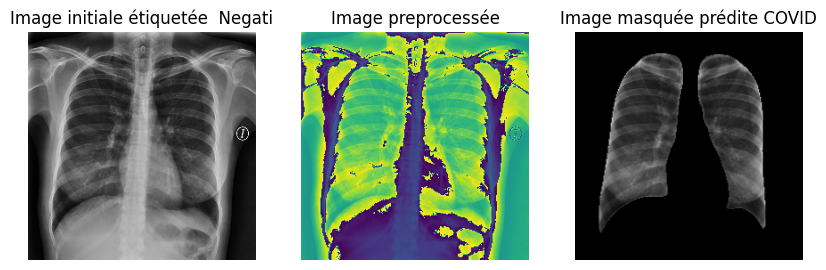

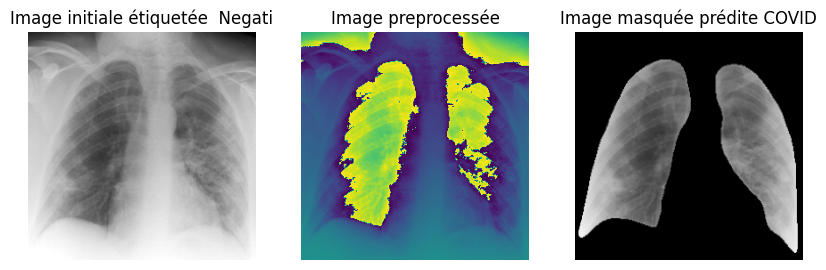

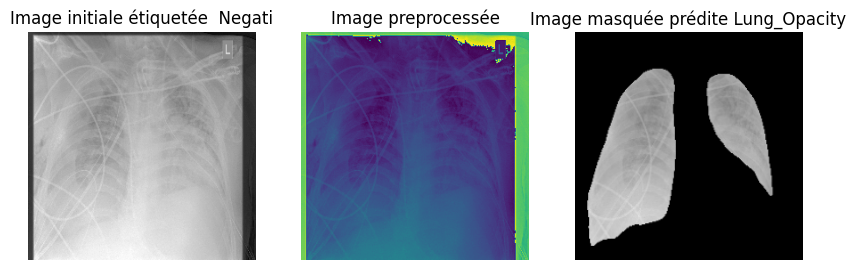

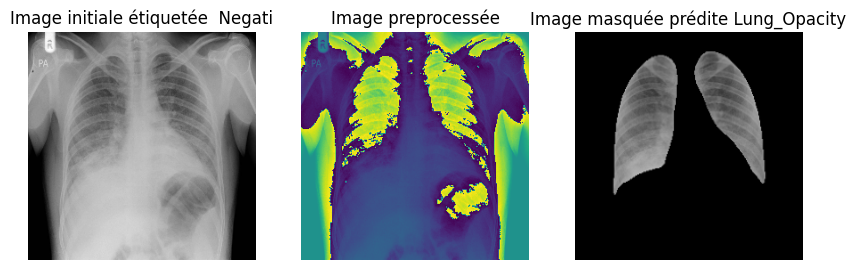

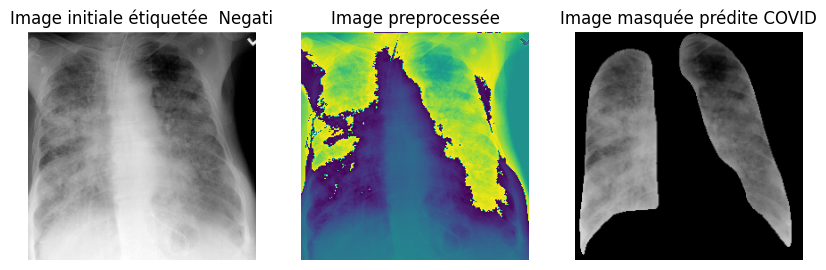

In [194]:
# Visualisation mal étiquetées

for j in range(10):
    i = random.randint(0,len(labels))
    if labels[i] != y_pred[i]:
       
        plt.figure(figsize=(10,5))
        
        plt.subplot(1,3,1)
        plt.imshow(images[i], cmap="gray")
        titre = "Image initiale étiquetée " + " " + y_true[i]
        plt.title(titre)
        plt.axis("off")

        
        plt.subplot(1,3,2)
        plt.imshow(images_scaled[i])
        titre = "Image preprocessée"
        plt.title(titre)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(masked_images[i])
        titre = "Image masquée prédite" + " " + y_pred[i]
        plt.title(titre)
        plt.axis("off")
        